In [54]:
!git clone https://github.com/Heet010/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [55]:
!ls Track
!pip install imgaug

driving_log.csv  IMG


In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [57]:
datadir = 'Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', 1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Dell\Desktop\Data\IMG\center_2024_06_21_02_49_55_963.jpg,C:\Users\Dell\Desktop\Data\IMG\left_2024_06_21_02_49_55_963.jpg,C:\Users\Dell\Desktop\Data\IMG\right_2024_06_21_02_49_55_963.jpg,0.0,0.0,0,0.000078
1,C:\Users\Dell\Desktop\Data\IMG\center_2024_06_21_02_49_56_067.jpg,C:\Users\Dell\Desktop\Data\IMG\left_2024_06_21_02_49_56_067.jpg,C:\Users\Dell\Desktop\Data\IMG\right_2024_06_21_02_49_56_067.jpg,0.0,0.0,0,0.000078
2,C:\Users\Dell\Desktop\Data\IMG\center_2024_06_21_02_49_56_172.jpg,C:\Users\Dell\Desktop\Data\IMG\left_2024_06_21_02_49_56_172.jpg,C:\Users\Dell\Desktop\Data\IMG\right_2024_06_21_02_49_56_172.jpg,0.0,0.0,0,0.000078
3,C:\Users\Dell\Desktop\Data\IMG\center_2024_06_21_02_49_56_274.jpg,C:\Users\Dell\Desktop\Data\IMG\left_2024_06_21_02_49_56_274.jpg,C:\Users\Dell\Desktop\Data\IMG\right_2024_06_21_02_49_56_274.jpg,0.0,0.0,0,0.000080
4,C:\Users\Dell\Desktop\Data\IMG\center_2024_06_21_02_49_56_375.jpg,C:\Users\Dell\Desktop\Data\IMG\left_2024_06_21_02_49_56_375.jpg,C:\Users\Dell\Desktop\Data\IMG\right_2024_06_21_02_49_56_375.jpg,0.0,0.0,0,0.000079


In [58]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_06_21_02_49_55_963.jpg,left_2024_06_21_02_49_55_963.jpg,right_2024_06_21_02_49_55_963.jpg,0.0,0.0,0,0.000078
1,center_2024_06_21_02_49_56_067.jpg,left_2024_06_21_02_49_56_067.jpg,right_2024_06_21_02_49_56_067.jpg,0.0,0.0,0,0.000078
2,center_2024_06_21_02_49_56_172.jpg,left_2024_06_21_02_49_56_172.jpg,right_2024_06_21_02_49_56_172.jpg,0.0,0.0,0,0.000078
3,center_2024_06_21_02_49_56_274.jpg,left_2024_06_21_02_49_56_274.jpg,right_2024_06_21_02_49_56_274.jpg,0.0,0.0,0,0.000080
4,center_2024_06_21_02_49_56_375.jpg,left_2024_06_21_02_49_56_375.jpg,right_2024_06_21_02_49_56_375.jpg,0.0,0.0,0,0.000079


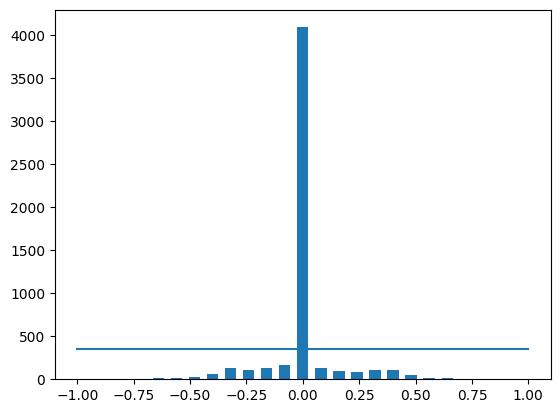

In [59]:
num_bins = 25
samples_per_bin = 350
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 5388
removed: 3739
remaining: 1649


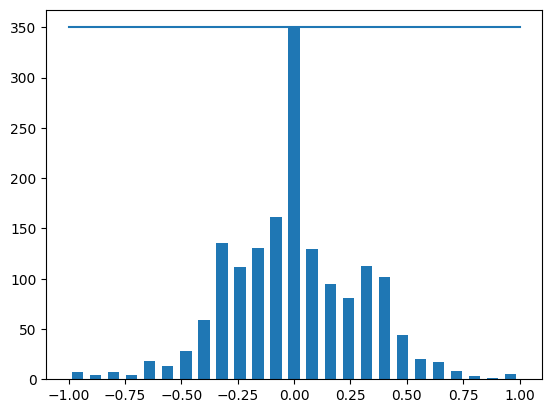

In [60]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [61]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

center      center_2024_06_21_02_49_56_583.jpg
left        left_2024_06_21_02_49_56_583.jpg  
right       right_2024_06_21_02_49_56_583.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0                                 
speed       0.000078                          
Name: 6, dtype: object


In [62]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3957
Valid Samples: 990


Text(0.5, 1.0, 'Validation set')

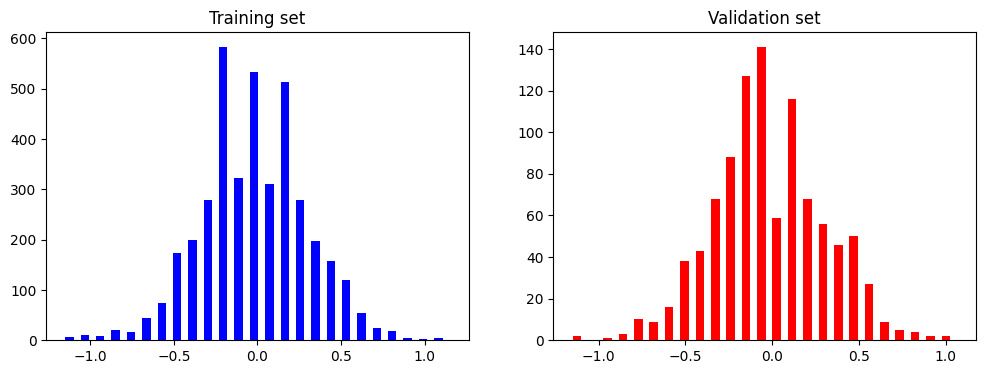

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [64]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

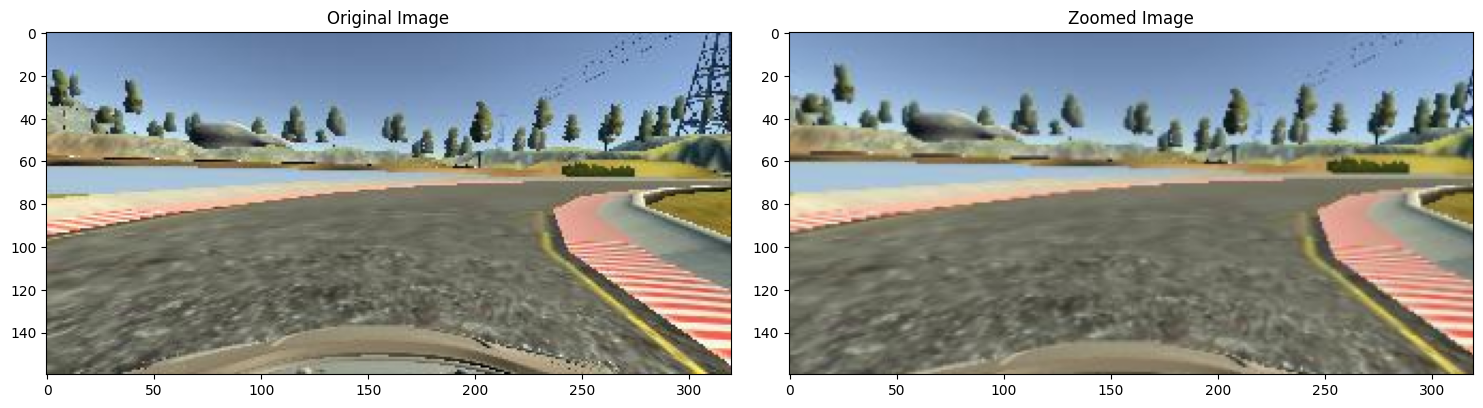

In [65]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [66]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

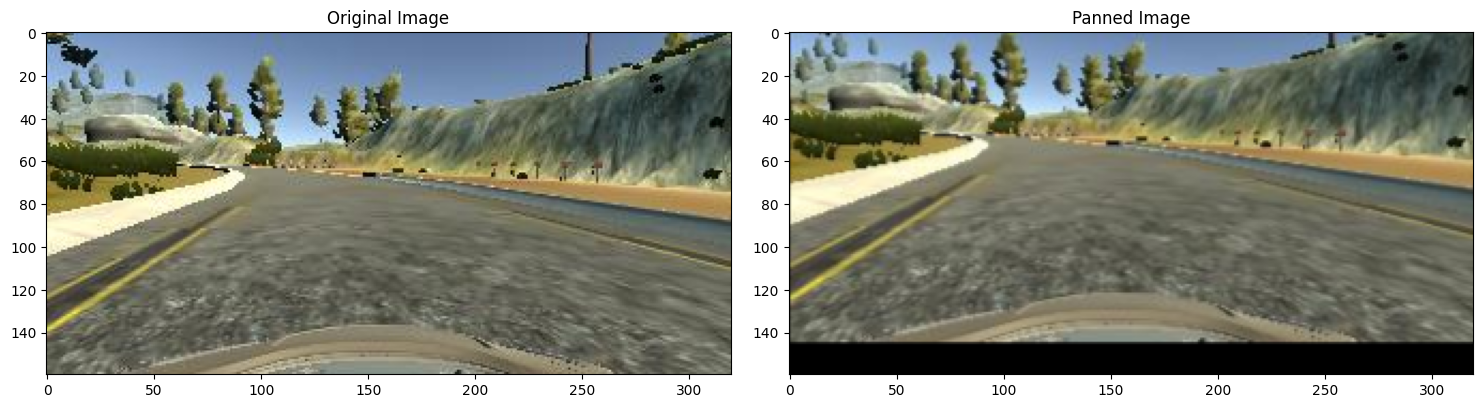

In [67]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [68]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

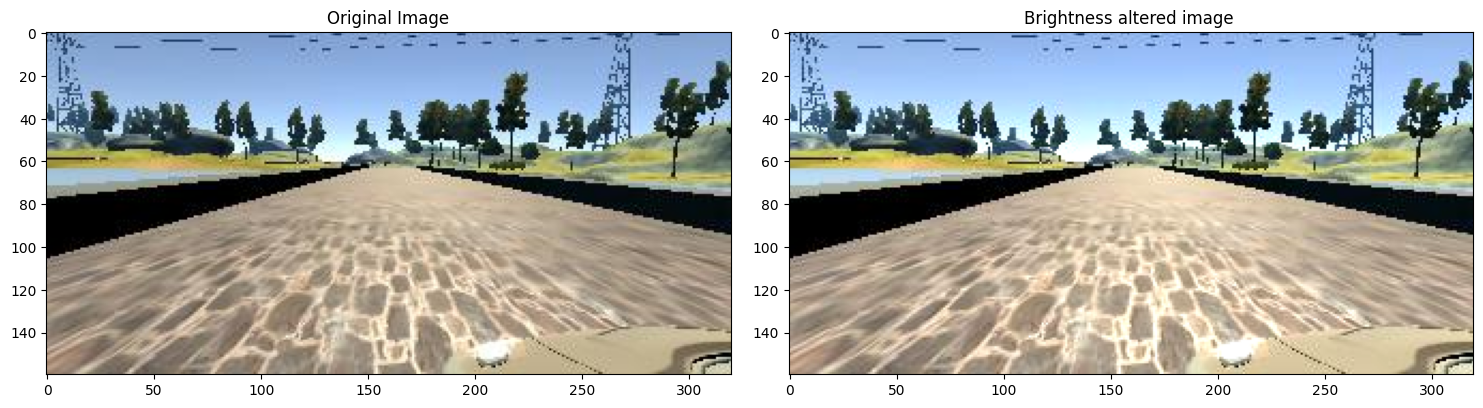

In [69]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [70]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.27788939999999995')

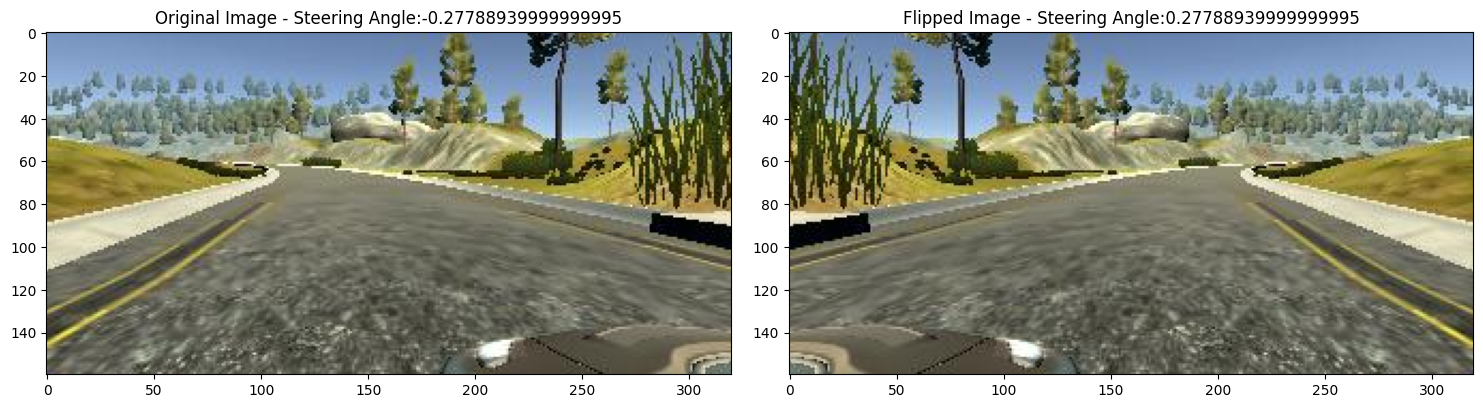

In [71]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [72]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [73]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Preprocessed Image')

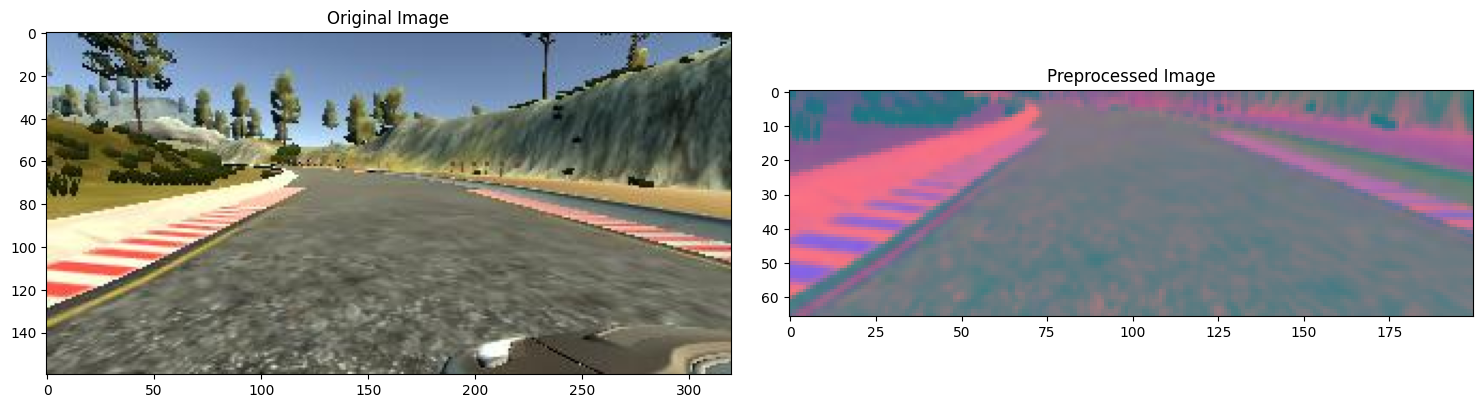

In [78]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [79]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

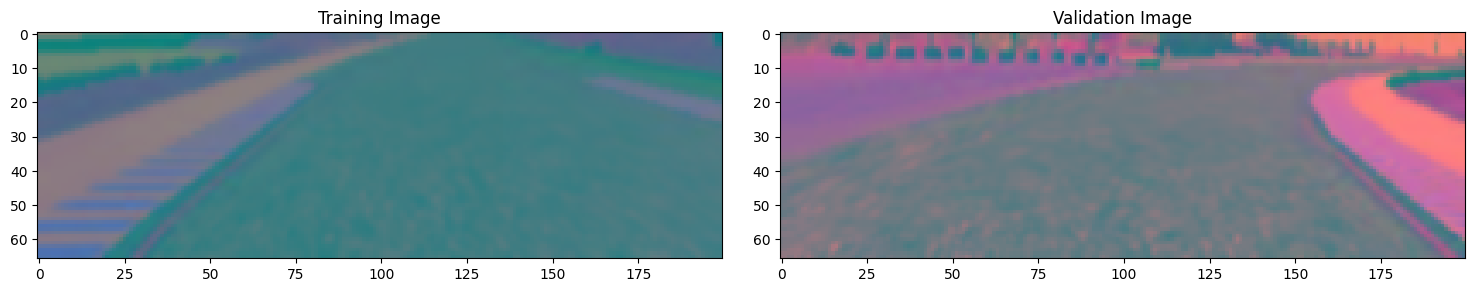

In [82]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [18]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(3957, 66, 200, 3)


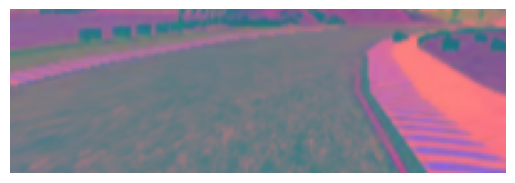

In [19]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [84]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))

  model.add(Convolution2D(64, (3, 3), activation='elu'))
  # model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [85]:
model = nvidia_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [86]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=6,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

<ipython-input-86-d82df037bffe>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/6
300/300 [==============================] - 364s 1s/step - loss: 0.1444 - val_loss: 0.1000
Epoch 2/6
300/300 [==============================] - 338s 1s/step - loss: 0.0837 - val_loss: 0.0720
Epoch 3/6
300/300 [==============================] - 341s 1s/step - loss: 0.0698 - val_loss: 0.0622
Epoch 4/6
300/300 [==============================] - 342s 1s/step - loss: 0.0640 - val_loss: 0.0538
Epoch 5/6
300/300 [==============================] - 351s 1s/step - loss: 0.0592 - val_loss: 0.0492
Epoch 6/6
300/300 [==============================] - 402s 1s/step - loss: 0.0534 - val_loss: 0.0468


Text(0.5, 0, 'Epoch')

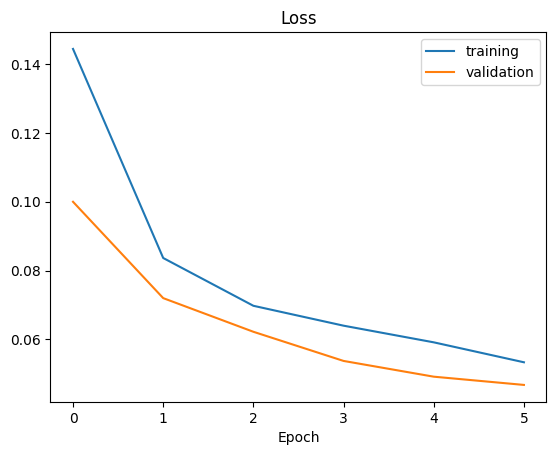

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [88]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>